In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
%pip install efficientnet
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum
import glob
%pip install pillow
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
from collections import Counter



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
num_epochs = 24
extra_to_majority = 2000
#extra_to_majority = 5
fake_data = 2
top_dropout_rate = 0.2



class SelectedModel(Enum):
    Eff0 = (224, 224)  # Example image size for EfficientNet 0
    Eff2 = (260, 260)  # Example image size for EfficientNet 2
    Eff4 = (380, 380)  # Example image size for EfficientNet 4
    ResNet50 = (224, 224)  # Example image size for ResNet50

    @property
    def image_size(self):
        return self.value
    def is_eff_family(self):
      return self in (SelectedModel.Eff0, SelectedModel.Eff2, SelectedModel.Eff4)


# Select the model
#my_mod = SelectedModel.ResNet50
my_mod = SelectedModel.Eff2

undersample_test = False

In [ ]:
from matplotlib.layout_engine import TightLayoutEngine
# Function to display images in a grid
def display_images_in_grid(images, labels, predictions=None, confidences=None, ncols=4):
  print("Num images: "+str(len(images)))
  nrows = (len(images) + ncols -1) // ncols

  plt.figure(figsize=(15, 10))

  for i in range(len(images)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))  # Read and display the image
    title="True: "+str(labels[i])
    if predictions:
      title += "\nPredicted: "+str(predictions[i])
    if confidences:
      title += "\nConfidence: "+str(confidences[i])

    plt.title(title)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

def predict_and_display_images_in_grid(model, data_gen, num_images_to_display = 16  ):
  #print(data_gen.class_indices)
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  print(class_labels)

  # plot a single image
  for x,y in data_gen:
    print("Plotting x which length"+str(len(x)))
    for i in range(len(x)):
      image = x[i]  # Get the ith image from the batch
      label_confidence=np.max(y[i])
      label_index = np.argmax(y[i])  # Get the index of the predicted class
      # Display the image
      plt.imshow(image)
      plt.title(f"Label: {class_labels[label_index]}\nConf: "+str(label_confidence))
      plt.grid(False)
      plt.show()
      if(i > 5):
        break
    break
  predictions = model.predict(data_gen)
  sample_size = min(num_images_to_display, len(predictions))
  sample_indices = random.sample(range(len(predictions)), sample_size)
  predict_confidence = [i for i in np.max(predictions, axis=1)]
  predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]
  ground_truth_labels = [class_labels[i] for i in data_gen.classes]
  #Select a subset of test images and labels to display

  image_file_names = data_gen.filenames

  # Display the images and their labels/predictions
  i_to_plot, g_to_plot, p_to_plot, c_to_plot = [],[],[],[]
  for i, idx in enumerate(sample_indices):
    i_to_plot.append(image_file_names[idx])
    g_to_plot.append(ground_truth_labels[idx])
    p_to_plot.append( predicted_labels[idx])
    c_to_plot.append(predict_confidence[idx])
  display_images_in_grid(
      i_to_plot,
      g_to_plot,
      p_to_plot,
      c_to_plot)
  # Calculate accuracy
  accuracy = accuracy_score(ground_truth_labels, predicted_labels)
  print("Accuracy: {:.2%}".format(accuracy))
  ret={}
  ret['accuracy']=accuracy
  ret['groundtruth']=ground_truth_labels
  ret['filenames']=image_file_names
  ret['predictions']=predicted_labels
  return ret
  #f1 = f1_score(ground_truth_labels, predicted_labels)
  #print("F1: {:.2%}".format(accuracy))
  #ret['f1']=f1
  #precision = precision_score(ground_truth_labels, predicted_labels)
  #print("Precision: {:.2%}".format(precision))
  #ret['precision']=precision
  #recall = recall_score(ground_truth_labels, predicted_labels)
  #print("Recall: {:.2%}".format(recall))
  #ret['recall']=recall

def show_confusion_matrix(truth, pred, title):
  print("Showing Confusion Matrix")
  print(len(truth))
  print(len(pred))
  accuracy = accuracy_score(truth, pred)
  print("Accuracy: {:.2%}".format(accuracy))

  conf_matrix = confusion_matrix(truth, pred)

  # Create a heatmap to visualize the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  plt.show()


def predict_and_display_images_in_folder(folder, model, image_gen, data_gen, target_sizes,  num_images_to_display = 16  ):
  #print(data_gen.class_indices)
  expected_classes=data_gen.class_indices.keys()
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  print(class_labels)
  p_list_full = []
  t_list_full = []
  for c in expected_classes:
    i_list = []
    p_list = []
    t_list = []
    png_files = glob.glob(os.path.join(folder+"/"+c, '*.png'))
    # Loop over the PNG files
    for png_file in png_files:
      if "mask" not in os.path.basename(png_file):
        img = image.load_img(png_file, target_size=target_sizes)
        img = image.img_to_array(img)
        img = preprocess_input(img)
        #image = Image.open(png_file)
        #print(type(image))
        #print(image.shape)
        #image = image.resize(target_sizes)
        print(type(img))
        print(img.shape)
        image_array = np.array(img).astype(np.float32)/256.0

        preprocessed_image = image_gen.standardize(image_array)  # This applies rescaling and other transformations
        # Perform evaluation using your model
        predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

        i_list.append(png_file)
        p_list.append(class_labels[np.argmax(predictions)])
        t_list.append(c)
    p_list_full.extend(p_list)
    t_list_full.extend(t_list)

    display_images_in_grid(i_list[:min(len(i_list), num_images_to_display)],
                           t_list[:min(len(i_list), num_images_to_display)],
                           p_list[:min(len(i_list), num_images_to_display)])
  show_confusion_matrix(t_list_full, p_list_full, "Confusion matrix")

def plot_sample_from_filenames(df):
  # Randomly select 16 indices from your DataFrame
  sample_indices = random.sample(range(len(df)), 16)

  # Create a subplot with 4 rows and 4 columns to display the images
  plt.figure(figsize=(10, 10))
  for i, idx in enumerate(sample_indices):
    image_path = df['filename'].iloc[idx]
    label = df['class'].iloc[idx]

    ax = plt.subplot(4, 4, i + 1)
    img = plt.imread(image_path)

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

  plt.show()

def plot_class_counts(df, xname):
  # Create a count plot using Seaborn
  plt.figure(figsize=(8, 6))
  sns.set(style='whitegrid')  # Set the style

  # Create the count plot
  sns.countplot(data=df, x=xname)

  # Set plot labels and title
  plt.xlabel(xname)
  plt.ylabel('Count')
  plt.title('Count of Each Class')

  # Show the plot
  plt.show()


# Define a custom function to filter out file paths containing "mask"
def filter_mask_images(image_paths, labels):
    filtered_paths, filtered_labels = [], []
    for path, label in zip(image_paths, labels):
        if "mask" not in os.path.basename(path):  # Check if "mask" is not in the filename
            filtered_paths.append(path)
            filtered_labels.append(label)
    return np.array(filtered_paths), np.array(filtered_labels)

class GeneratorType(Enum):
  TRAIN=1
  TEST=2
  INFERENCE=3

def create_generator(given_df, image_size, batch_size, augment=False, gen_type=GeneratorType.TRAIN):
  # Create an ImageDataGenerator for reading and preprocessing the images
  # Normalize the intensitities to [0,1]
  rescale = 1./255
  #color_mode = 'grayscale'
  color_mode='rgb'
  image_generator=None
  if gen_type is GeneratorType.TRAIN:
    print("Creating Train")
    image_generator = ImageDataGenerator(rescale=rescale)
  elif gen_type is GeneratorType.TEST:
    print("Creating Test")
    image_generator = ImageDataGenerator(rescale=rescale)
  elif gen_type is GeneratorType.INFERENCE:
    print("Creating Inference")
    image_generator = ImageDataGenerator(rescale=rescale, to_fit=False)
    return [image_generator.flow_from_dataframe(
      given_df,
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=False,
      seed=42,
      color_mode=color_mode), image_generator]
  else:
    print("Unexpected value for gen_type="+str(gen_type))
    exit()
  if augment:
    return [image_generator.flow_from_dataframe(
        given_df,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42,
        zoom_range=.4,
        horizontal_flip=True,
        rotation_range=40,
        width_shift_range=.3,
        height_shift_range=.3,
        fill_mode='nearest',
        color_mode=color_mode), image_generator]
  return [image_generator.flow_from_dataframe(
      given_df,
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      seed=42,
      color_mode=color_mode), image_generator]

  import random

def undersample_list_pair(vals, labels):
  # Count the occurrences of each label in labels
  label_counts = Counter(labels)
  # Find the minimum count among label occurrences
  min_count = min(label_counts.values())
  # Undersample A and B to the minimum count for each label
  vals_undersampled = []
  labels_undersampled = []

  for label in label_counts:
    # Get the indices of elements in labels with the current label
    indices = [i for i, item in enumerate(labels) if item == label]

    # Randomly select 'min_count' indices for undersampling
    undersampled_indices = random.sample(indices, min_count)

    # Add the corresponding elements to A_prime and B_prime
    vals_undersampled.extend([vals[i] for i in undersampled_indices])
    labels_undersampled.extend([labels[i] for i in undersampled_indices])
  return [vals_undersampled, labels_undersampled]



In [ ]:

# Define the directory where your images are stored
base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT'
if fake_data == 1:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake'
elif fake_data == 2:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake2'


# Define your image dimensions and batch size
image_size = my_mod.image_size
batch_size = 32

# Create an ImageDataGenerator for reading and preprocessing the images
# Normalize the intensitities to [0,1]
image_generator_unfiltered = ImageDataGenerator(rescale=1./255)

unfiltered_data_generator = image_generator_unfiltered.flow_from_directory(
    base_directory,
    target_size=image_size,  # Set the target image size
    batch_size=batch_size,
    class_mode='categorical',  # For multiple classes, use 'categorical'
    shuffle=True  # set this to False if you want to preserve the order
)

# Load the image file paths and labels
print(unfiltered_data_generator.classes  )



Found 48 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
class_labels = {value: key for key, value in unfiltered_data_generator.class_indices.items()}
image_paths, labels = filter_mask_images(unfiltered_data_generator.filepaths, [class_labels[i] for i in unfiltered_data_generator.classes])
print("Image path size = "+str(len(image_paths)))

Image path size = 48


Creating Train
Found 38 validated image filenames belonging to 3 classes.
Creating Train
Found 38 validated image filenames belonging to 3 classes.
Creating Train
Found 10 validated image filenames belonging to 3 classes.
Creating Train
Found 10 validated image filenames belonging to 3 classes.


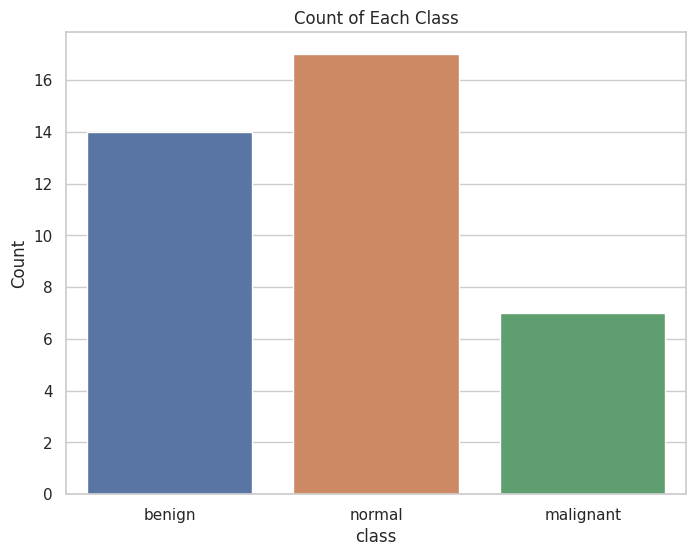

                                                              filename   class
0   ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/benign/img12.png  benign
1  ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/benign/img110.png  benign
2  ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/benign/img113.png  benign
3  ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img219.png  normal
4  ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img213.png  normal


In [ ]:

train_image_paths, test_image_paths_full, train_labels, test_labels_full = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
if undersample_test:
  test_image_paths, test_labels = undersample_list_pair(test_image_paths_full, test_labels_full)
else:
  test_image_paths=test_image_paths_full
  test_labels=test_labels_full
# Create separate data generators for training and testing
train_data_generator, train_image_generator = create_generator(
    pd.DataFrame({'filename': train_image_paths, 'class': train_labels}),
    image_size,
    batch_size,
    GeneratorType.TRAIN)
train_data_generator_inference, train_image_generator_inference = create_generator(
    pd.DataFrame({'filename': train_image_paths, 'class': train_labels}),
    image_size,
    batch_size,
    GeneratorType.INFERENCE)


test_data_generator, test_image_generator = create_generator(
    pd.DataFrame({'filename': test_image_paths, 'class': test_labels}),
    image_size,
    batch_size,
    GeneratorType.TEST)
test_data_generator_inference, test_image_generator_inference = create_generator(
    pd.DataFrame({'filename': test_image_paths, 'class': test_labels}),
    image_size,
    batch_size,
    GeneratorType.INFERENCE)

# Convert the class indices to class labels
class_labels = list(train_data_generator.class_indices.keys())

# Create a DataFrame with the train image file paths and labels
df = pd.DataFrame({
    'filename': train_data_generator.filepaths,
    'class': [class_labels[i] for i in train_data_generator.classes]
})



pd.set_option('display.max_colwidth', None)
plot_class_counts(df, "class")
# Display the first few rows of the DataFrame
print(df.head())

Creating Train
Found 17 validated image filenames belonging to 1 classes.
Creating Train
Found 7 validated image filenames belonging to 1 classes.
Creating Train
Found 14 validated image filenames belonging to 1 classes.
2000
2010
2003


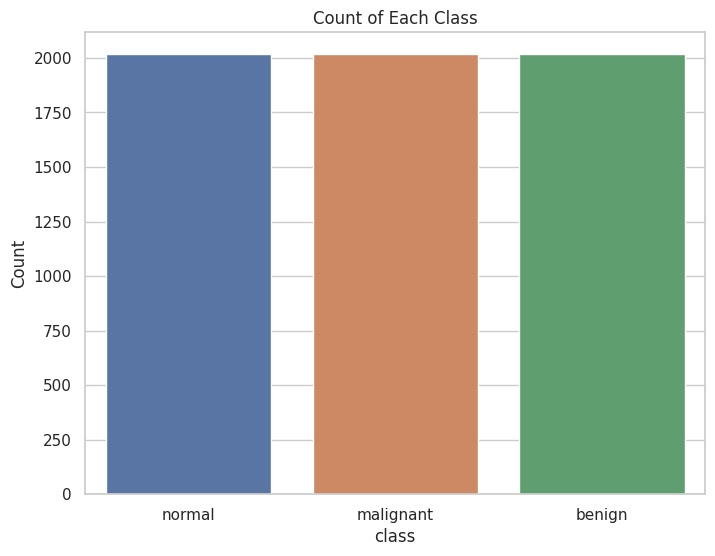

                                                               filename  \
3   ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img219.png   
4   ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img213.png   
7    ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img27.png   
11   ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img21.png   
12  ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img212.png   

     class  
3   normal  
4   normal  
7   normal  
11  normal  
12  normal  
Creating Train
Found 6051 validated image filenames belonging to 3 classes.


In [ ]:
# Create DataFrames for each class
df_normal = df[df['class'] == 'normal']
df_malignant = df[df['class'] == 'malignant']
df_benign = df[df['class'] == 'benign']
# Calculate the number of samples in the majority class
majority_count = max(len(df_normal), len(df_malignant), len(df_benign)) + extra_to_majority



# Oversample 'normal' class
normal_generator, normal_image_gen = create_generator(
    df_normal,
    image_size,
    majority_count - len(df_normal),
    True,
    GeneratorType.TRAIN
)

# Oversample 'malignant' class
malignant_generator, malignant_image_gen = create_generator(
    df_malignant,
    image_size,
    majority_count - len(df_malignant),
    True,
    GeneratorType.TRAIN
)

# Oversample 'benign' class
benign_generator, benign_image_gen = create_generator(
    df_benign,
    image_size,
    majority_count - len(df_benign),
    True,
    GeneratorType.TRAIN
)
aa=df_normal.sample(majority_count - len(df_normal), replace=True)
bb=df_malignant.sample(majority_count - len(df_malignant), replace=True)
cc=df_benign.sample(majority_count - len(df_benign), replace=True)
print(len(aa))
print(len(bb))
print(len(cc))

# Concatenate the oversampled dataframes
augmented_data = pd.concat([df_normal, df_malignant, df_benign,
                            aa,bb,cc])

# Now 'augmented_data' contains your balanced dataset with augmented data
df=augmented_data
plot_class_counts(df, "class")
# Display the first few rows of the DataFrame
print(df.head())
train_data_generator_aug, train_image_generator_aug = create_generator(
    df,
    image_size,
    batch_size,
    GeneratorType.TRAIN)


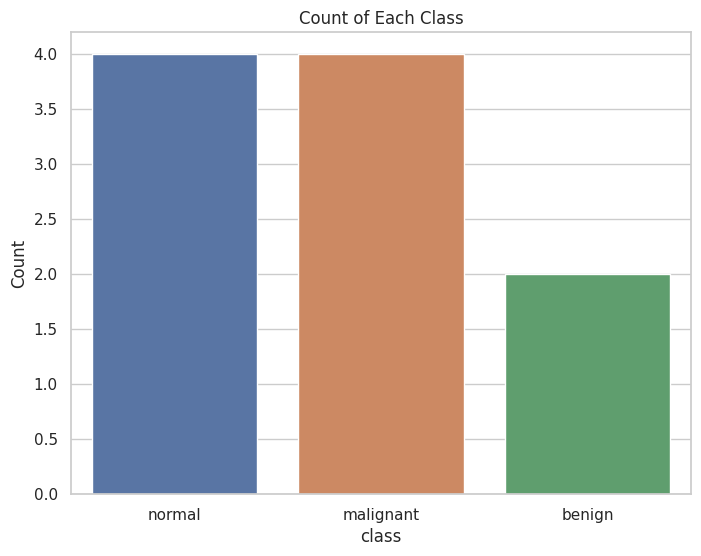

                                                                filename  \
0      ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img2.png   
1     ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img22.png   
2  ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/malignant/img39.png   
3     ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/normal/img25.png   
4  ./drive/MyDrive/ML/BreastCancerProject/data/Fake2/malignant/img37.png   

       class  
0     normal  
1     normal  
2  malignant  
3     normal  
4  malignant  


In [ ]:

class_labels_test = list(test_data_generator.class_indices.keys())
# Create a DataFrame with the train image file paths and labels
df_test = pd.DataFrame({
    'filename': test_data_generator.filepaths,
    'class': [class_labels_test[i] for i in test_data_generator.classes]
})

pd.set_option('display.max_colwidth', None)
plot_class_counts(df_test, "class")
# Display the first few rows of the DataFrame
print(df_test.head())

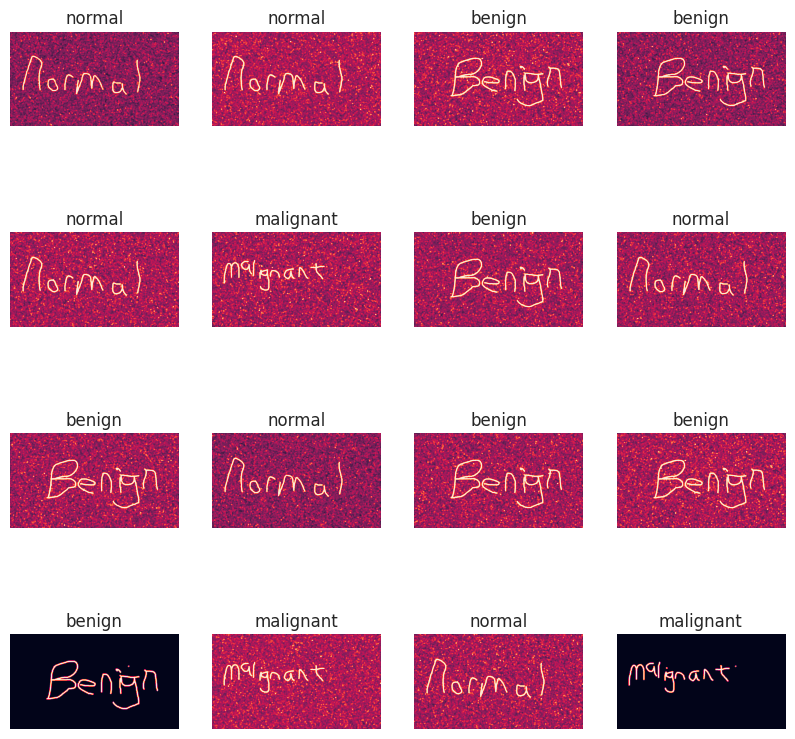

In [ ]:


plot_sample_from_filenames(df)


In [ ]:
num_classes = 3
base_model = None
if True:
  if my_mod is SelectedModel.Eff0:
    base_model= EfficientNetB0(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff2:
    base_model= EfficientNetB2(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff4:
    base_model= EfficientNetB4(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))
  elif my_mod is SelectedModel.ResNet50:
      base_model = ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(image_size[0], image_size[1], 3))
  else:
    print("Unexpected model type "+str(my_mod))
    exit()
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001),  # You can adjust the learning rate
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 260, 260, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 130, 130, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 130, 130, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 130, 130, 32)         0         ['stem_bn[0][0]']         

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Define a learning rate schedule function
def lr_schedule(epoch):

    if epoch < 6:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define a ModelCheckpoint callback to save the best model during training
best_model = 'best_model'+str(image_size[0])+'.h5'
model_checkpoint = ModelCheckpoint(best_model, save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

# Define an EarlyStopping callback to stop training if the validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train your model and use the callbacks
history = model.fit(
    train_data_generator_aug,
    epochs=num_epochs,
    validation_data=test_data_generator,
    callbacks=[model_checkpoint, early_stopping, lr_scheduler],
    verbose=1,  # Set verbose to 1 to display training progress,
)
model.load_weights(best_model)


Epoch 1/24
190/190 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9873
Epoch 1: val_loss improved from inf to 0.01592, saving model to best_model260.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


190/190 [==============================] - 168s 564ms/step - loss: 0.0414 - accuracy: 0.9873 - val_loss: 0.0159 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/24
190/190 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980
Epoch 2: val_loss improved from 0.01592 to 0.00005, saving model to best_model260.h5
190/190 [==============================] - 102s 535ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 5.1281e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/24
190/190 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9970
Epoch 3: val_loss did not improve from 0.00005
190/190 [==============================] - 102s 535ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 5.2564e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/24
190/190 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9998
Epoch 4: val_loss improved from 0.00005 to 0.00001, saving model to best_model260.h5
190/190 [==============================] - 

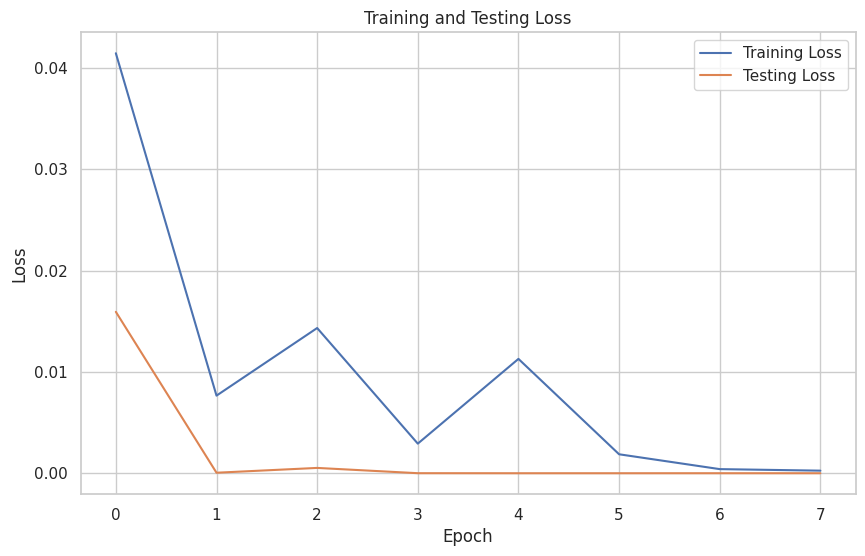

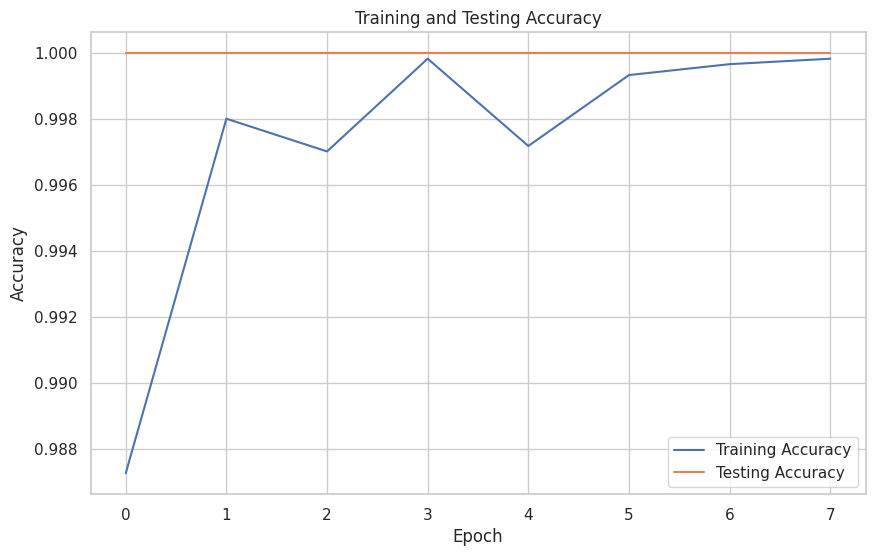

In [ ]:


# Assuming you've trained your model and have the `history` object
# The `history` object typically contains 'loss' and 'val_loss' values

# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


{0: 'benign', 1: 'malignant', 2: 'normal'}
Plotting x which length10


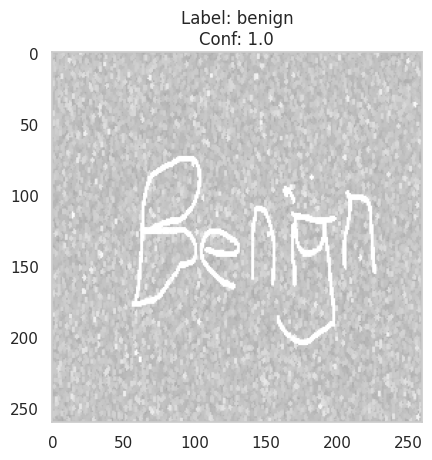

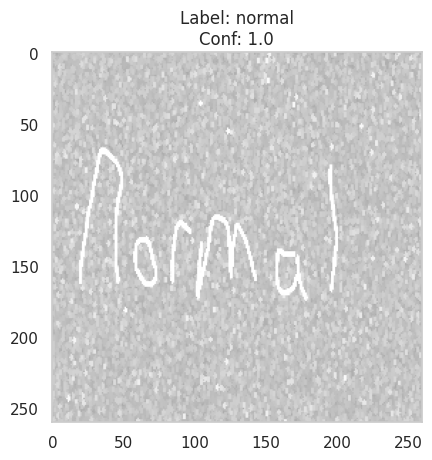

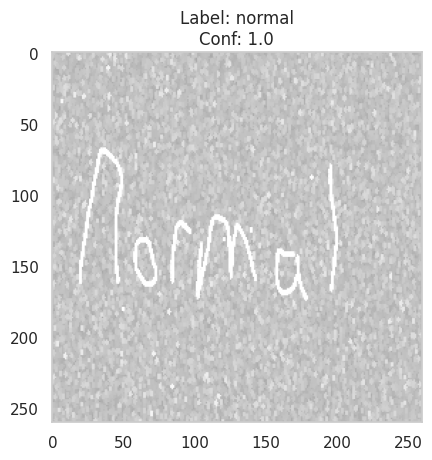

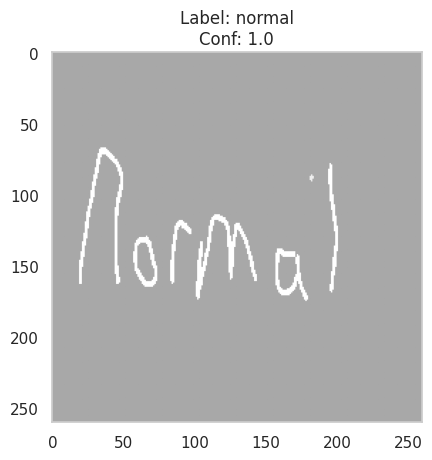

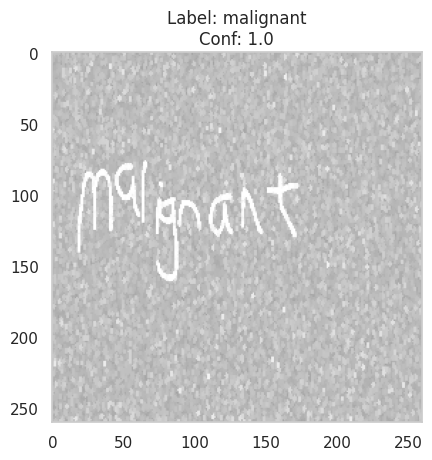

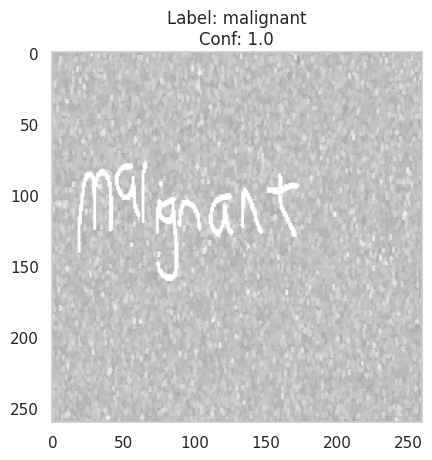

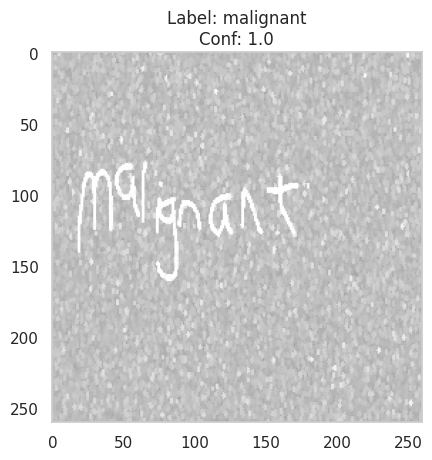

1/1 [==============================] - 0s 369ms/step
Num images: 10


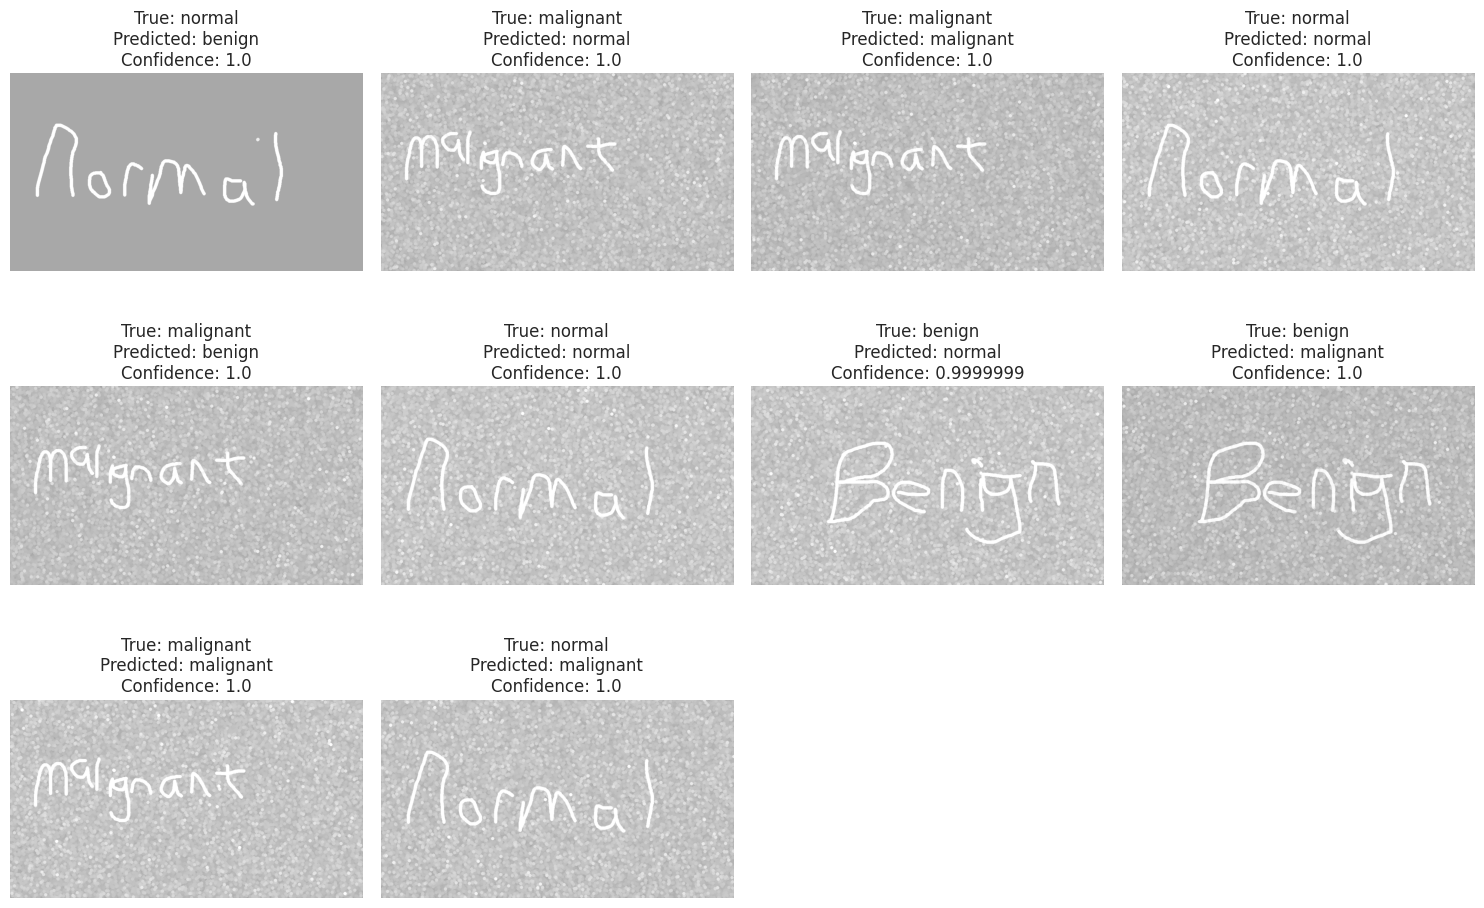

Accuracy: 40.00%
10
10


In [ ]:
results=predict_and_display_images_in_grid(model, test_data_generator_inference)
ground_truth_labels=results['groundtruth']
predicted_labels=results['predictions']
print(len(ground_truth_labels))
print(len(predicted_labels))

In [ ]:
results_training=predict_and_display_images_in_grid(model, train_data_generator_inference);
ground_truth_labels_training=results_training['groundtruth']
predicted_labels_training=results_training['predictions']

print(len(ground_truth_labels_training))
print(len(predicted_labels_training))

Output hidden; open in https://colab.research.google.com to view.

Showing Confusion Matrix
10
10
Accuracy: 40.00%


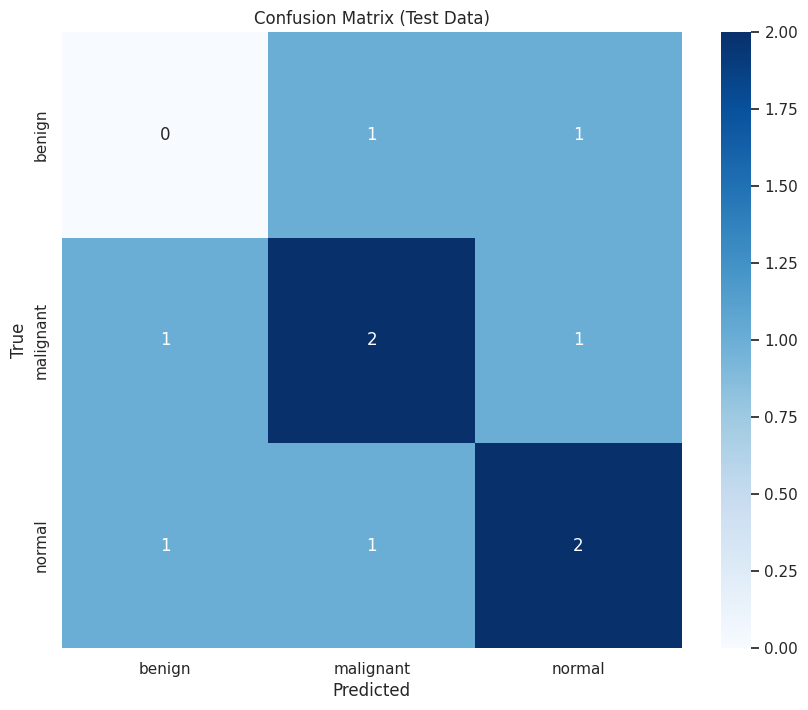

Showing Confusion Matrix
38
38
Accuracy: 26.32%


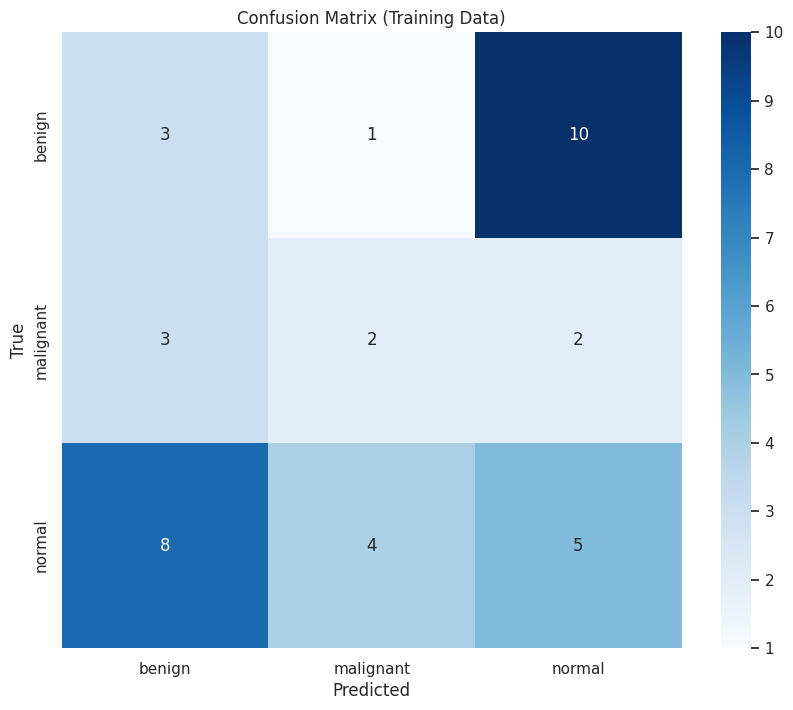

In [ ]:

show_confusion_matrix(ground_truth_labels, predicted_labels, "Confusion Matrix (Test Data)")
show_confusion_matrix(ground_truth_labels_training, predicted_labels_training, "Confusion Matrix (Training Data)")

In [ ]:
predict_and_display_images_in_folder(base_directory, model,train_image_generator_inference, train_data_generator_inference ,image_size, 16)

Output hidden; open in https://colab.research.google.com to view.